# GENSIM WORD2VEC EXPERIMENT
**CONTENT**
* BROWN DATA PREPARATION
* GENSIM.WORD2VEC MODEL
* EXPERIMENT 1: BAD DATA (INTERESTED VS. NOT-INTERESTED)
* EXPERIMENT 2: GOOD DATA (MSR SPAM COLLECTION)

## TRAINING DATA: BROWN CORPUS
**NB: FOR PREPARATION, DO NOT RUN THIS SECTION FIRST**

In [38]:
from nltk.corpus import brown, stopwords
from nltk.stem.porter import PorterStemmer

In [60]:
%%time
words, sents = list(brown.words()), list(brown.sents())

CPU times: user 11.9 s, sys: 187 ms, total: 12.1 s
Wall time: 12.2 s


In [62]:
stop = stopwords.words('english')

In [63]:
def brown_clean(sents):
    sents = [[str(word.lower()) for word in sent] for sent in sents] # unicode->string, lowercasing.
    sents = [[word for word in sent if word not in stop] for sent in sents] # removing stopwords.
    sents = [[PorterStemmer().stem(word) for word in sent] for sent in sents] # lemmatizing.
    return sents
def brown_vocab_build(words):
    return list(set([PorterStemmer().stem(str(word.lower())) for word in words if str(word.lower()) not in stop]))

In [65]:
%%time
words = brown_vocab_build(words)
words = [str(word) for word in words] # somehow unicode->string needs to be performed again.

CPU times: user 23 s, sys: 204 ms, total: 23.2 s
Wall time: 23.2 s


In [66]:
%%time
sents = brown_clean(sents)

CPU times: user 22.3 s, sys: 197 ms, total: 22.5 s
Wall time: 22.5 s


In [67]:
print sents[0]
print words[0]

[u'fulton', u'counti', u'grand', u'juri', u'said', u'friday', u'investig', u"atlanta'", u'recent', u'primari', u'elect', u'produc', u'``', u'evid', u"''", u'irregular', u'took', u'place', u'.']
fawn


## GENSIM WORD2VEC MODEL

In [196]:
from gensim.models import Word2Vec
    # Word2Vec params:
    #  - size: dimensionality of feature vectors.
    #  - window: the maximum distance between the current and predicted word within a sentence.
    #  - alpha: initial learning rate.
    #  - seed: seed for random number generator.
    #  - min_count: ignore all words with total frequency lower than this.
    #  - max_vocab_size: limit RAM during vocab building.
    #  - sample: threshold for configuring which higher-frequency words are randomly downsampled
    #      default=1e-3, useful range is (0, 1e-5).
    #  - workers: use this many worker threads to train the model (i.e. faster with multicore machines)
    #  - iter: number of iterations over corpus.
    #  ... for the rest see https://radimrehurek.com/gensim/models/word2vec.html.

In [197]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from keras.utils.np_utils import to_categorical
%matplotlib inline

In [198]:
import os
os.chdir('/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/OJO/SPAM_INTEREST_TASKS/DATA')

In [199]:
joshdata = pd.read_excel('sentiment_josh.xlsx')
joshdata.head()

,0,1
0,She has indeed contacted me I have n't contact...,1
1,The round of interviews went very well . Still...,2
2,It looks like my first reply might not have go...,2
3,We will be in Austin May NUMBER for the next r...,2
4,- MLS # NUMBER is by far my top choice because...,2


In [200]:
cristinadata = pd.read_excel('sentiment_cristina.xlsx')
jacobdata = pd.read_excel('sentiment_jacob.xlsx')

In [201]:
X = np.concatenate((joshdata[0].values, cristinadata[0].values, jacobdata[0].values))
y = np.concatenate((joshdata[1].values, cristinadata[1].values, jacobdata[1].values))
y[618] = 1.
y[706] = 1.
y[1472] = 1.
y = to_categorical(y)
print X[0]
print y[0]

She has indeed contacted me I have n't contacted her back because I 'm waiting to hear more about my husband 's job opportunity . He will be flying to Austin the day after Easter to continue the interviews and after that we should know more . If you could tell her that I will gladly contact her after that set of interviews that would be great
[ 0.  1.  0.]


In [202]:
def sent_clean(sent):
    sent = nltk.word_tokenize(sent) # still unicode.
#     sent = [word for word in sent if word not in stop] # removing stopwords.
    sent = [PorterStemmer().stem(word.lower()) for word in sent]
    return sent
def build_vocab(sents): # used after sent_clean operation.
    vocab = []
    for sent in sents:
        vocab.extend(sent)
    return list(set(vocab))

In [203]:
X = map(sent_clean, X)
vocab = build_vocab(X)

In [204]:
print X[0]
print vocab[:10]

[u'she', u'ha', u'inde', u'contact', u'me', u'i', u'have', u"n't", u'contact', u'her', u'back', u'becaus', u'i', u"'m", u'wait', u'to', u'hear', u'more', u'about', u'my', u'husband', u"'s", u'job', u'opportun', u'.', u'he', u'will', u'be', u'fli', u'to', u'austin', u'the', u'day', u'after', u'easter', u'to', u'continu', u'the', u'interview', u'and', u'after', u'that', u'we', u'should', u'know', u'more', u'.', u'if', u'you', u'could', u'tell', u'her', u'that', u'i', u'will', u'gladli', u'contact', u'her', u'after', u'that', u'set', u'of', u'interview', u'that', u'would', u'be', u'great']
[u'smtp.homecity.com', u'lolthank', u'number-a', u'6pm', u'oldest', u'hate', u'whose', u'aug', u'sorri', u'deviat']


### ====================== COMMON CODE ENDS HERE ======================

In [40]:
%%time
model = Word2Vec(X, size=5, window=4) # words -> 10D vecs.

CPU times: user 542 ms, sys: 22.5 ms, total: 564 ms
Wall time: 241 ms


In [41]:
# WORD -> VECTOR
def vectorize(model, sent): # sent -> list word vector in model.
    return [model[word] for word in sent if word in model.vocab]

In [378]:
type(X)

list

In [42]:
X_vec = [vectorize(model,sent) for sent in X] # X_vec is now a list of lists of 10D vectors
                                              #                 ^        ^            ^
                                              #                 |        |            |
                                              #               corpus   sentence     word

# BAD DATASET: INTEREST VS. NOT INTEREST

## MODEL 1: MLP

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.preprocessing import sequence
from sklearn.cross_validation import train_test_split

Average Sentence Length: 64


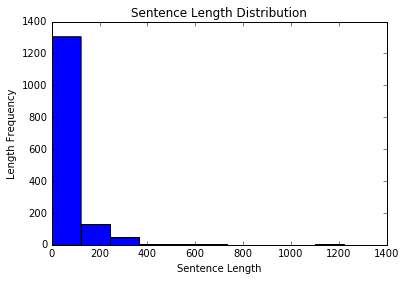

In [24]:
sentLens = [len(sent) for sent in X_vec]
meanLens = int(np.mean(sentLens))
print 'Average Sentence Length: %d' % meanLens
plt.hist(sentLens)
plt.title('Sentence Length Distribution')
plt.xlabel('Sentence Length')
plt.ylabel('Length Frequency')
plt.show()
# NB: BUT WE'LL TAKE 60.

In [25]:
# INPUT SIZE UNIFORMIZATION
# FLATTENING
def flatten(sents):
    return [word for sent in sents for word in sent]
padding = np.array([0.,0.,0.,0.,0.], dtype='float32')
for i in range(len(X_vec)):
    if len(X_vec[i]) > 60:
        X_vec[i] = X_vec[i][:60]
    else: 
        X_vec[i] += [padding for _ in range(60-len(X_vec[i]))]
X_vec = map(np.array, X_vec) # to np.array, so that .shape attribute is available.
X_vec = map(flatten, X_vec)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=.2)

In [27]:
# MLP BUILDING
model = Sequential()
model.add(Dense(100, input_dim=300, init='normal', activation='relu'))
model.add(Dense(50, init='normal', activation='relu'))
model.add(Dense(3, init='normal', activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print model.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
dense_1 (Dense)                    (None, 100)         30100       dense_input_1[0][0]              
____________________________________________________________________________________________________
dense_2 (Dense)                    (None, 50)          5050        dense_1[0][0]                    
____________________________________________________________________________________________________
dense_3 (Dense)                    (None, 3)           153         dense_2[0][0]                    
Total params: 35303
____________________________________________________________________________________________________
None


In [371]:
%%time
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=10, batch_size=50, verbose=1)
scores = model.evaluate(X_test, y_test, verbose=0)
print 'Accuracy: %.2f%%' % (scores[1]*100)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 8.11 µs
Train on 1200 samples, validate on 300 samples
Epoch 1/10
1200/1200 [==============================] - 0s - loss: 1.0032 - acc: 0.4983 - val_loss: 0.9919 - val_acc: 0.5400
Epoch 2/10
1200/1200 [==============================] - 0s - loss: 0.8997 - acc: 0.6100 - val_loss: 0.9454 - val_acc: 0.5567
Epoch 3/10
1200/1200 [==============================] - 0s - loss: 0.8362 - acc: 0.6417 - val_loss: 0.9236 - val_acc: 0.5600
Epoch 4/10
1200/1200 [==============================] - 0s - loss: 0.7658 - acc: 0.6617 - val_loss: 0.9161 - val_acc: 0.5900
Epoch 5/10
1200/1200 [==============================] - 0s - loss: 0.6986 - acc: 0.6850 - val_loss: 0.8844 - val_acc: 0.5533
Epoch 6/10
1200/1200 [==============================] - 0s - loss: 0.6506 - acc: 0.7117 - val_loss: 0.8613 - val_acc: 0.5767
Epoch 7/10
1200/1200 [==============================] - 0s - loss: 0.6137 - acc: 0.7300 - val_loss: 0.8667 - val_acc: 0.5967
Epoch 8/10

## MODEL 2: CNN

In [189]:
from keras.layers import Convolution2D, MaxPooling2D, Dropout
from keras.constraints import maxnorm

In [190]:
%%time
model = Word2Vec(X, size=5, window=4) # words -> 5 vecs.

CPU times: user 546 ms, sys: 20 ms, total: 566 ms
Wall time: 239 ms


In [191]:
# SENTENCES -> MATRICES 
#  - each word is a row of 5D vector.
#  - normalization size: 60.
X_mat = [[model[word] for word in sent if word in model.vocab] for sent in X]
padding = np.array([0.,0.,0.,0.,0.], dtype='float32')
for i in range(len(X_mat)):
    if len(X_mat[i]) > 60:
        X_mat[i] = X_mat[i][:60]
    else: 
        X_mat[i] += [padding for _ in range(60-len(X_mat[i]))]
X_mat = map(np.array, X_mat) # to np.array, integrate individual flaot32 objs into 1 matrix.
X_mat = np.array(X_mat)
X_mat = X_mat.reshape(X_mat.shape[0], 1, 60, 5)
print 'Dimensions of EACH Sentence-Matrix: (%d, %d, %d)' % X_mat[0].shape
print 'Dimensions of ENTIRE Dataset: (%d, %d, %d, %d)' % X_mat.shape

Dimensions of EACH Sentence-Matrix: (1, 60, 5)
Dimensions of ENTIRE Dataset: (1500, 1, 60, 5)


In [192]:
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=.2)

### OPTIMIZATION 1: ADAM

In [32]:
# MODEL BUILDING
model = Sequential()
model.add(Convolution2D(30, 3, 3, input_shape=(1,60,5), border_mode='same', activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(.2))
model.add(Convolution2D(15, 3, 3, activation='relu', border_mode='same', W_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print model.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
convolution2d_1 (Convolution2D)    (None, 30, 60, 5)   300         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
dropout_1 (Dropout)                (None, 30, 60, 5)   0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)    (None, 15, 60, 5)   4065        dropout_1[0][0]                  
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)      (None, 15, 30, 2)   0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [469]:
# MODEL FITTING & EVALUATION
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=25, batch_size=50, verbose=1)
scores = model.evaluate(X_test, y_test, verbose=0)
print 'Accuracy: %.2f%%' % (scores[1]*100)

Train on 1200 samples, validate on 300 samples
Epoch 1/25
1200/1200 [==============================] - 1s - loss: 1.2828 - acc: 0.4908 - val_loss: 0.9881 - val_acc: 0.6033
Epoch 2/25
1200/1200 [==============================] - 1s - loss: 0.9094 - acc: 0.5783 - val_loss: 0.9009 - val_acc: 0.5867
Epoch 3/25
1200/1200 [==============================] - 1s - loss: 0.8693 - acc: 0.5933 - val_loss: 0.9105 - val_acc: 0.5967
Epoch 4/25
1200/1200 [==============================] - 1s - loss: 0.8353 - acc: 0.6033 - val_loss: 0.9051 - val_acc: 0.6067
Epoch 5/25
1200/1200 [==============================] - 1s - loss: 0.7768 - acc: 0.6408 - val_loss: 0.8126 - val_acc: 0.6567
Epoch 6/25
1200/1200 [==============================] - 1s - loss: 0.7402 - acc: 0.6467 - val_loss: 0.8106 - val_acc: 0.6700
Epoch 7/25
1200/1200 [==============================] - 1s - loss: 0.6939 - acc: 0.6883 - val_loss: 0.8017 - val_acc: 0.6467
Epoch 8/25
1200/1200 [==============================] - 1s - loss: 0.6687 - ac

### OPTIMIZATION 2: SGD

In [33]:
from keras.optimizers import SGD

In [34]:
# MODEL BUILDING
model = Sequential()
model.add(Convolution2D(30, 3, 3, input_shape=(1,60,5), border_mode='same', activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(.2))
model.add(Convolution2D(15, 3, 3, activation='relu', border_mode='same', W_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(3, activation='softmax'))
epochs = 25
lrate = .01
decay = lrate / epochs
sgd = SGD(lr=lrate, momentum=.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print model.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
convolution2d_3 (Convolution2D)    (None, 30, 60, 5)   300         convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
dropout_3 (Dropout)                (None, 30, 60, 5)   0           convolution2d_3[0][0]            
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)    (None, 15, 60, 5)   4065        dropout_3[0][0]                  
____________________________________________________________________________________________________
maxpooling2d_2 (MaxPooling2D)      (None, 15, 30, 2)   0           convolution2d_4[0][0]            
___________________________________________________________________________________________

In [466]:
# MODEL FITTING & EVALUATION
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=epochs, batch_size=50, verbose=1)
scores = model.evaluate(X_test, y_test, verbose=0)
print 'Accuracy: %.2f%%' % (scores[1]*100)

Train on 1200 samples, validate on 300 samples
Epoch 1/25
1200/1200 [==============================] - 1s - loss: 1.2144 - acc: 0.4817 - val_loss: 0.9562 - val_acc: 0.5733
Epoch 2/25
1200/1200 [==============================] - 1s - loss: 0.9364 - acc: 0.5742 - val_loss: 0.9117 - val_acc: 0.6033
Epoch 3/25
1200/1200 [==============================] - 1s - loss: 0.9162 - acc: 0.5675 - val_loss: 0.8962 - val_acc: 0.6200
Epoch 4/25
1200/1200 [==============================] - 1s - loss: 0.8613 - acc: 0.6025 - val_loss: 0.8552 - val_acc: 0.6200
Epoch 5/25
1200/1200 [==============================] - 1s - loss: 0.8419 - acc: 0.6083 - val_loss: 0.8855 - val_acc: 0.6000
Epoch 6/25
1200/1200 [==============================] - 1s - loss: 0.8087 - acc: 0.6183 - val_loss: 0.8358 - val_acc: 0.6233
Epoch 7/25
1200/1200 [==============================] - 1s - loss: 0.7817 - acc: 0.6250 - val_loss: 0.8298 - val_acc: 0.6333
Epoch 8/25
1200/1200 [==============================] - 1s - loss: 0.7292 - ac

### ACCURACY & CONVERGENCE

Accuracy: 72.67%


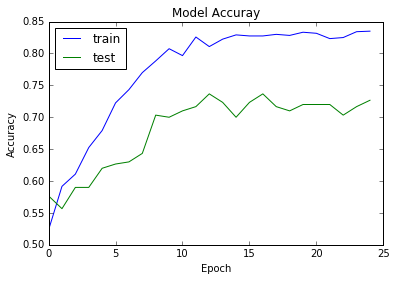

In [40]:
# ADAM OPTIMIZATION
model = Sequential()
model.add(Convolution2D(30, 3, 3, input_shape=(1,60,5), border_mode='same', activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(.2))
model.add(Convolution2D(15, 3, 3, activation='relu', border_mode='same', W_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=25, batch_size=50, verbose=0)
scores = model.evaluate(X_test, y_test, verbose=0)
print 'Accuracy: %.2f%%' % (scores[1]*100)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuray')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

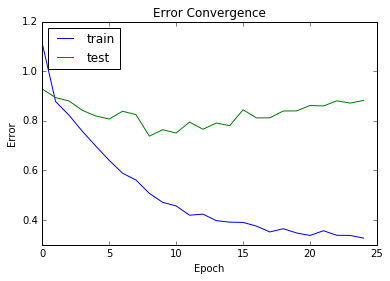

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Error Convergence')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Accuracy: 72.33%


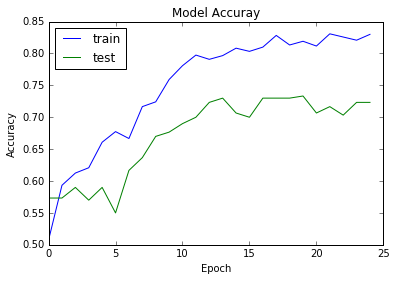

In [36]:
# SGD OPTIMIZATION
model = Sequential()
model.add(Convolution2D(30, 3, 3, input_shape=(1,60,5), border_mode='same', activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(.2))
model.add(Convolution2D(15, 3, 3, activation='relu', border_mode='same', W_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(3, activation='softmax'))
epochs = 25
lrate = .01
decay = lrate / epochs
sgd = SGD(lr=lrate, momentum=.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=epochs, batch_size=50, verbose=0)
scores = model.evaluate(X_test, y_test, verbose=0)
print 'Accuracy: %.2f%%' % (scores[1]*100)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuray')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

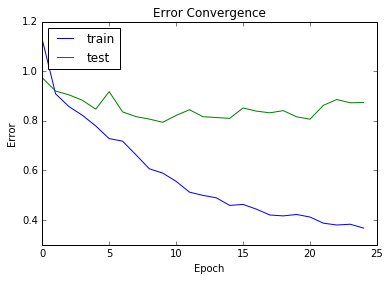

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Error Convergence')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 5 x 60 x 1 DIM CNN EXPERIMENT

In [205]:
import numpy as np
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from sklearn.cross_validation import train_test_split

In [206]:
%%time
# WORD2VEC
model = Word2Vec(X, size=5, window=4) # words -> 5 vecs.

CPU times: user 543 ms, sys: 18.6 ms, total: 562 ms
Wall time: 238 ms


In [207]:
# SENTENCES -> MATRICES 
#  - each word is a row of 5D vector.
#  - normalization size: 60.
X_mat = [[model[word] for word in sent if word in model.vocab] for sent in X]
padding = np.array([0.,0.,0.,0.,0.], dtype='float32')
for i in range(len(X_mat)):
    if len(X_mat[i]) > 60:
        X_mat[i] = X_mat[i][:60]
    else: 
        X_mat[i] += [padding for _ in range(60-len(X_mat[i]))]
X_mat = map(np.array, X_mat) # to np.array, integrate individual flaot32 objs into 1 matrix.
X_mat = np.array(X_mat)
X_mat = X_mat.reshape(X_mat.shape[0], 1, 60, 5)
print 'Dimensions of EACH Sentence-Matrix: (%d, %d, %d)' % X_mat[0].shape
print 'Dimensions of ENTIRE Dataset: (%d, %d, %d, %d)' % X_mat.shape

Dimensions of EACH Sentence-Matrix: (1, 60, 5)
Dimensions of ENTIRE Dataset: (1500, 1, 60, 5)


In [208]:
# SENT --JOSH_TRANSFORMATION--> SENT
def transform(sent):
    return np.array([ [ [w[i]] for w in sent ] for i in range(sent.shape[1]) ])
X_mat5CH = np.array([ transform(sent[0]) for sent in X_mat ]) # 5 channel.

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X_mat5CH, y, test_size=.2)
print X_mat5CH.shape
print X_train[0].shape

(1500, 5, 60, 1)
(5, 60, 1)


### OPTIMIZATION 1: ADAM
* **NO DIFFERENCE BETWEEN ADAM & SGD, FOR MORE PARAMS TRIALS SEE "OPTIMIZATION 2: SGD"**

In [211]:
%%time
# MODEL BUILDING
model = Sequential()
model.add(Convolution2D(30, 1, 1, input_shape=(5,60,1), border_mode='same', activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(.2))
model.add(Convolution2D(15, 1, 1, activation='relu', border_mode='same', W_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2,1))) 
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print model.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
convolution2d_27 (Convolution2D)   (None, 30, 60, 1)   180         convolution2d_input_14[0][0]     
____________________________________________________________________________________________________
dropout_19 (Dropout)               (None, 30, 60, 1)   0           convolution2d_27[0][0]           
____________________________________________________________________________________________________
convolution2d_28 (Convolution2D)   (None, 15, 60, 1)   465         dropout_19[0][0]                 
____________________________________________________________________________________________________
maxpooling2d_12 (MaxPooling2D)     (None, 15, 30, 1)   0           convolution2d_28[0][0]           
___________________________________________________________________________________________

In [213]:
%%time
# MODEL FITTING & EVALUATION
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=25, batch_size=50, verbose=1)
scores = model.evaluate(X_test, y_test, verbose=0)
print 'Accuracy: %.2f%%' % (scores[1]*100)

Train on 1200 samples, validate on 300 samples
Epoch 1/25
1200/1200 [==============================] - 0s - loss: 0.3704 - acc: 0.8317 - val_loss: 0.7789 - val_acc: 0.7500
Epoch 2/25
1200/1200 [==============================] - 0s - loss: 0.3808 - acc: 0.8158 - val_loss: 0.7704 - val_acc: 0.7567
Epoch 3/25
1200/1200 [==============================] - 0s - loss: 0.3779 - acc: 0.8233 - val_loss: 0.7396 - val_acc: 0.7533
Epoch 4/25
1200/1200 [==============================] - 0s - loss: 0.3528 - acc: 0.8358 - val_loss: 0.7552 - val_acc: 0.7467
Epoch 5/25
1200/1200 [==============================] - 0s - loss: 0.3567 - acc: 0.8275 - val_loss: 0.7779 - val_acc: 0.7400
Epoch 6/25
1200/1200 [==============================] - 0s - loss: 0.3361 - acc: 0.8400 - val_loss: 0.7789 - val_acc: 0.7533
Epoch 7/25
1200/1200 [==============================] - 0s - loss: 0.3543 - acc: 0.8158 - val_loss: 0.7939 - val_acc: 0.7533
Epoch 8/25
1200/1200 [==============================] - 0s - loss: 0.3626 - ac

Accuracy: 72.67%


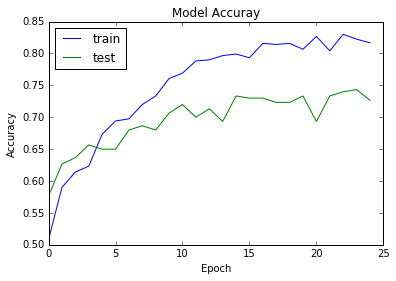

CPU times: user 11.2 s, sys: 398 ms, total: 11.6 s
Wall time: 9.83 s


In [214]:
%%time
# ACCURACY CHECKING
model = Sequential()
model.add(Convolution2D(30, 1, 1, input_shape=(5,60,1), border_mode='same', activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(.2))
model.add(Convolution2D(15, 1, 1, activation='relu', border_mode='same', W_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2,1))) 
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=25, batch_size=50, verbose=0)
scores = model.evaluate(X_test, y_test, verbose=0)
print 'Accuracy: %.2f%%' % (scores[1]*100)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuray')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

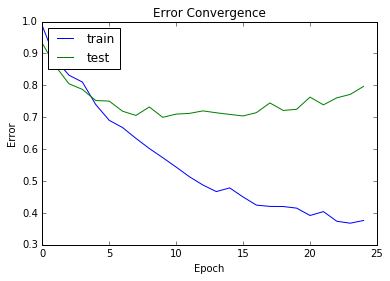

In [215]:
# CONVERGENCE CHECKING
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Error Convergence')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### OPTIMIZATION 2: SGD

#### REDNECK'S GRIDSEARCH 1: HAMMERING ON FNN
* **WIDE FNN**
    * FNN = 128->3
        * 50 epochs: ~75%
        * 100 epochs: ~74%
        * 200 epochs: ~75%
    * FNN = 512->3
        * 25 epochs: ~73%
        * 100 epochs: ~74%
        * 500 epochs: ~74%
* **DEEP FNN**
    * FNN = 50->50->3
        * 50 epochs: ~75%
        * 100 epochs: ~74%
        * 200 epochs: ~74%
    * FNN = 50->50->50->50->3
        * 200 epochs: ~75%
* **SUPER BIG-ASS FNN**
    * FNN = 500->500->500->500->3
        * 50 epochs: ~75

#### REDNECK'S GRIDSEARCH 2: CHISELING AWAY AT CNN
* **FMAP (DENSE = 100->3)**
    * 30-15: ~74% in previous tests (50, 200 epochs)
    * 100-50: ~74% (50 epochs)

**CONCLUSION**: LOST CAUSE.

Train on 1200 samples, validate on 300 samples
Epoch 1/50
1200/1200 [==============================] - 1s - loss: 1.0265 - acc: 0.5108 - val_loss: 0.8827 - val_acc: 0.6133
Epoch 2/50
1200/1200 [==============================] - 1s - loss: 0.8864 - acc: 0.5808 - val_loss: 0.8124 - val_acc: 0.6267
Epoch 3/50
1200/1200 [==============================] - 1s - loss: 0.8334 - acc: 0.6033 - val_loss: 0.7858 - val_acc: 0.6367
Epoch 4/50
1200/1200 [==============================] - 1s - loss: 0.7733 - acc: 0.6433 - val_loss: 0.7642 - val_acc: 0.6567
Epoch 5/50
1200/1200 [==============================] - 1s - loss: 0.7301 - acc: 0.6875 - val_loss: 0.7236 - val_acc: 0.6600
Epoch 6/50
1200/1200 [==============================] - 1s - loss: 0.6700 - acc: 0.7125 - val_loss: 0.7461 - val_acc: 0.6700
Epoch 7/50
1200/1200 [==============================] - 1s - loss: 0.6407 - acc: 0.7300 - val_loss: 0.6875 - val_acc: 0.6800
Epoch 8/50
1200/1200 [==============================] - 1s - loss: 0.5946 - ac

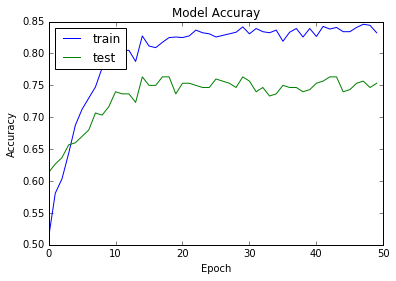

CPU times: user 1min 8s, sys: 5.07 s, total: 1min 13s
Wall time: 1min 5s


In [237]:
%%time
# MODEL BUILDING & RUNNING & ACCURACY CHECKING
model = Sequential()
model.add(Convolution2D(100, 5, 1, input_shape=(5,60,1), border_mode='same', activation='relu'))
model.add(Dropout(.2))
model.add(Convolution2D(50, 5, 1, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size=(2,1))) 
model.add(Flatten())
model.add(Dense(100, activation='relu'))
# model.add(Dense(500, activation='relu'))
# model.add(Dense(500, activation='relu'))
# model.add(Dense(500, activation='relu'))
# model.add(Dropout(.2))
model.add(Dense(3, activation='softmax'))
epochs = 50
lrate = .01
decay = lrate / epochs
sgd = SGD(lr=lrate, momentum=.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=epochs, batch_size=50, verbose=1)
scores = model.evaluate(X_test, y_test, verbose=0)
print 'Accuracy: %.2f%%' % (scores[1]*100)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuray')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

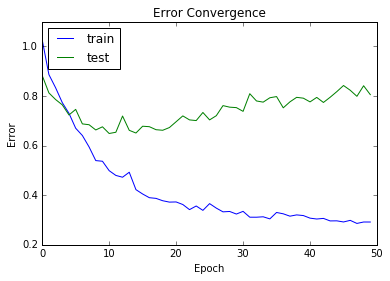

In [238]:
# CONVERGENCE CHECKING
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Error Convergence')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# GOOD DATASET: MSR SPAM COLLECTION

### DATA PREPARATION

In [260]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [422]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.preprocessing import sequence
from sklearn.cross_validation import train_test_split

In [423]:
from gensim.models import Word2Vec

In [424]:
# LOAD DATA
data = pd.read_csv('/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/OJO/SPAM_INTEREST_TASKS/DATA/SMSSpamCollection',
                   delimiter='\t', header=None)

In [425]:
X, y = data[1], data[0]

In [426]:
def sent_clean(sent):
    sent = nltk.word_tokenize(sent.decode('ascii','ignore')) # still unicode.
    sent = [str(PorterStemmer().stem(word.lower())) for word in sent]
    return sent

In [427]:
X = map(sent_clean, X) # X: tokenized, lowercased, lemmatized.

In [428]:
y = [1 if label=='ham' else 0 for label in y] # y: 0, 1 labels.

Average Sentence Length: 15


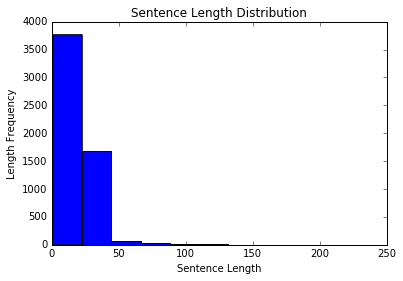

In [429]:
sentLens = map(len, X)
meanLens = np.median(sentLens)
print 'Average Sentence Length: %d' % meanLens
plt.hist(sentLens)
plt.title('Sentence Length Distribution')
plt.xlabel('Sentence Length')
plt.ylabel('Length Frequency')
plt.show()

In [466]:
# WORD -> VECTOR
def vectorize(model, sent): # sent -> list word vector in model.
    return [model[word] for word in sent if word in model.vocab]

In [467]:
%%time
# WORD2VEC
w2v = Word2Vec(X, size=5, window=4)

CPU times: user 558 ms, sys: 32.8 ms, total: 591 ms
Wall time: 258 ms


In [468]:
####################
##### MLP CELL ##### 
####################
X_vec = [vectorize(w2v,sent) for sent in X]
# # INPUT SIZE UNIFORMIZATION
# # FLATTENING
# def flatten(sents):
#     return [word for sent in sents for word in sent]
# padding = np.array([0.,0.,0.,0.,0.], dtype='float32')
# for i in range(len(X_vec)):
#     if len(X_vec[i]) > 15:
#         X_vec[i] = X_vec[i][:15]
#     else: 
#         X_vec[i] += [padding for _ in range(15-len(X_vec[i]))]
# X_vec = map(np.array, X_vec) # to np.array, so that .shape attribute is available.
# X_vec = map(flatten, X_vec)

In [469]:
X_mat = [[w2v[word] for word in sent if word in w2v.vocab] for sent in X]
padding = np.array([0.,0.,0.,0.,0.], dtype='float32')
for i in range(len(X_mat)):
    if len(X_mat[i]) > 15:
        X_mat[i] = X_mat[i][:15]
    else: 
        X_mat[i] += [padding for _ in range(15-len(X_mat[i]))]
X_mat = map(np.array, X_mat) # to np.array, integrate individual flaot32 objs into 1 matrix.
X_mat = np.array(X_mat)
X_mat = X_mat.reshape(X_mat.shape[0], 1, 15, 5)
print 'Dimensions of EACH Sentence-Matrix: (%d, %d, %d)' % X_mat[0].shape
print 'Dimensions of ENTIRE Dataset: (%d, %d, %d, %d)' % X_mat.shape

Dimensions of EACH Sentence-Matrix: (1, 15, 5)
Dimensions of ENTIRE Dataset: (5572, 1, 15, 5)


### A. NON-JOSH METHOD
* **TRAIN PERFORMANCE**
    * Near perfect after 50 epochs (~86% -> ~99%).
* **TEST PERFORMANCE**
    * First 50 epoch: ~93% -> ~95%
    * 50-200 epoch: Flat.

In [470]:
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=.2)

In [471]:
# MODEL BUILDING
model = Sequential()
model.add(Convolution2D(30, 3, 3, input_shape=(1,15,5), border_mode='same', activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(.2))
model.add(Convolution2D(15, 3, 3, activation='relu', border_mode='same', W_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(1, activation='sigmoid'))
epochs = 200
lrate = .01
decay = lrate / epochs
sgd = SGD(lr=lrate, momentum=.9, decay=decay, nesterov=False)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
print model.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
convolution2d_89 (Convolution2D)   (None, 30, 15, 5)   300         convolution2d_input_45[0][0]     
____________________________________________________________________________________________________
dropout_66 (Dropout)               (None, 30, 15, 5)   0           convolution2d_89[0][0]           
____________________________________________________________________________________________________
convolution2d_90 (Convolution2D)   (None, 15, 15, 5)   4065        dropout_66[0][0]                 
____________________________________________________________________________________________________
maxpooling2d_43 (MaxPooling2D)     (None, 15, 7, 2)    0           convolution2d_90[0][0]           
___________________________________________________________________________________________

Train on 4457 samples, validate on 1115 samples
Epoch 1/200
4457/4457 [==============================] - 1s - loss: 0.3583 - acc: 0.8678 - val_loss: 0.1907 - val_acc: 0.9327
Epoch 2/200
4457/4457 [==============================] - 1s - loss: 0.2095 - acc: 0.9224 - val_loss: 0.1746 - val_acc: 0.9417
Epoch 3/200
4457/4457 [==============================] - 1s - loss: 0.1790 - acc: 0.9396 - val_loss: 0.1426 - val_acc: 0.9462
Epoch 4/200
4457/4457 [==============================] - 1s - loss: 0.1612 - acc: 0.9426 - val_loss: 0.1344 - val_acc: 0.9489
Epoch 5/200
4457/4457 [==============================] - 1s - loss: 0.1541 - acc: 0.9464 - val_loss: 0.1289 - val_acc: 0.9543
Epoch 6/200
4457/4457 [==============================] - 1s - loss: 0.1566 - acc: 0.9450 - val_loss: 0.1571 - val_acc: 0.9516
Epoch 7/200
4457/4457 [==============================] - 1s - loss: 0.1427 - acc: 0.9488 - val_loss: 0.1344 - val_acc: 0.9587
Epoch 8/200
4457/4457 [==============================] - 1s - loss: 0.

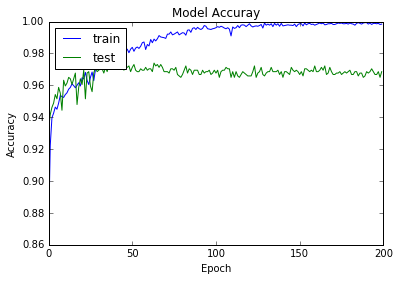

In [472]:
# MODEL FITTING & ACCURACY EVALUATION
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=epochs, batch_size=50, verbose=1)
scores = model.evaluate(X_test, y_test, verbose=0)
print 'Accuracy: %.2f%%' % (scores[1]*100)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuray')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

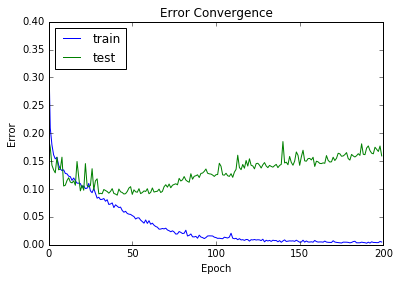

In [473]:
# ERROR CONVERGENCE
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Error Convergence')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### B. JOSH METHOD
* **TRAIN PERFORMANCE**
    * Near perfect after 50 epochs (~88% -> ~99%).
* **TEST PERFORMANCE**
    * First 50 epoch: ~92% -> ~96%
    * 50-200 epoch: Flat.

In [480]:
# SENT --JOSH_TRANSFORMATION--> SENT
def transform(sent):
    return np.array([ [ [w[i]] for w in sent ] for i in range(sent.shape[1]) ])
X_mat5CH = np.array([ transform(sent[0]) for sent in X_mat ]) # 5 channel.
X_train, X_test, y_train, y_test = train_test_split(X_mat5CH, y, test_size=.2)
print X_mat5CH.shape
print X_train[0].shape

(5572, 5, 15, 1)
(5, 15, 1)


Train on 4457 samples, validate on 1115 samples
Epoch 1/200
4457/4457 [==============================] - 0s - loss: 0.3227 - acc: 0.8777 - val_loss: 0.2312 - val_acc: 0.9103
Epoch 2/200
4457/4457 [==============================] - 0s - loss: 0.2153 - acc: 0.9217 - val_loss: 0.2645 - val_acc: 0.8960
Epoch 3/200
4457/4457 [==============================] - 0s - loss: 0.1825 - acc: 0.9322 - val_loss: 0.1953 - val_acc: 0.9166
Epoch 4/200
4457/4457 [==============================] - 0s - loss: 0.1651 - acc: 0.9387 - val_loss: 0.1236 - val_acc: 0.9543
Epoch 5/200
4457/4457 [==============================] - 0s - loss: 0.1571 - acc: 0.9448 - val_loss: 0.1260 - val_acc: 0.9543
Epoch 6/200
4457/4457 [==============================] - 0s - loss: 0.1485 - acc: 0.9441 - val_loss: 0.1328 - val_acc: 0.9525
Epoch 7/200
4457/4457 [==============================] - 0s - loss: 0.1331 - acc: 0.9497 - val_loss: 0.1253 - val_acc: 0.9587
Epoch 8/200
4457/4457 [==============================] - 0s - loss: 0.

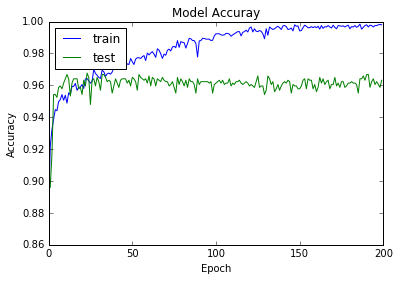

In [481]:
# MODEL BUILDING & RUNNING & ACCURACY CHECKING
model = Sequential()
model.add(Convolution2D(30, 3, 1, input_shape=(5,15,1), border_mode='same', activation='relu'))
model.add(Dropout(.2))
model.add(Convolution2D(15, 3, 1, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size=(2,1))) 
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
epochs = 200
lrate = .01
decay = lrate / epochs
sgd = SGD(lr=lrate, momentum=.9, decay=decay, nesterov=False)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=epochs, batch_size=50, verbose=1)
scores = model.evaluate(X_test, y_test, verbose=0)
print 'Accuracy: %.2f%%' % (scores[1]*100)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuray')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

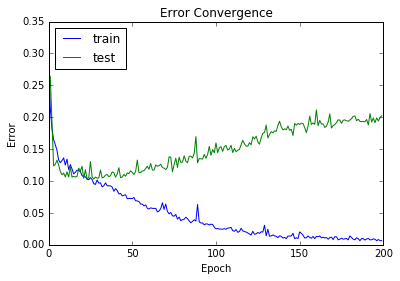

In [482]:
# ERROR CONVERGENCE
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Error Convergence')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# CONVOLUTION1D EXPERIMENT

In [13]:
import nltk
from nltk.stem import PorterStemmer
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from keras.utils.np_utils import to_categorical
%matplotlib inline

In [18]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.utils import np_utils
from sklearn.cross_validation import train_test_split

In [5]:
from gensim.models import Word2Vec

In [9]:
import os
os.chdir('/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/OJO/SPAM_INTEREST_TASKS/DATA')
joshdata = pd.read_excel('sentiment_josh.xlsx')
joshdata.head()

,0,1
0,She has indeed contacted me I have n't contact...,1
1,The round of interviews went very well . Still...,2
2,It looks like my first reply might not have go...,2
3,We will be in Austin May NUMBER for the next r...,2
4,- MLS # NUMBER is by far my top choice because...,2


In [10]:
cristinadata = pd.read_excel('sentiment_cristina.xlsx')
jacobdata = pd.read_excel('sentiment_jacob.xlsx')
X = np.concatenate((joshdata[0].values, cristinadata[0].values, jacobdata[0].values))
y = np.concatenate((joshdata[1].values, cristinadata[1].values, jacobdata[1].values))
y[618] = 1.
y[706] = 1.
y[1472] = 1.
y = to_categorical(y)
print X[0]
print y[0]

She has indeed contacted me I have n't contacted her back because I 'm waiting to hear more about my husband 's job opportunity . He will be flying to Austin the day after Easter to continue the interviews and after that we should know more . If you could tell her that I will gladly contact her after that set of interviews that would be great
[ 0.  1.  0.]


In [14]:
def sent_clean(sent):
    sent = nltk.word_tokenize(sent) # still unicode.
    sent = [PorterStemmer().stem(word.lower()) for word in sent]
    return sent
def build_vocab(sents): # used after sent_clean operation.
    vocab = []
    for sent in sents:
        vocab.extend(sent)
    return list(set(vocab))
X = map(sent_clean, X)
vocab = build_vocab(X)
print X[0]
print vocab[:10]

[u'she', u'ha', u'inde', u'contact', u'me', u'i', u'have', u"n't", u'contact', u'her', u'back', u'becaus', u'i', u"'m", u'wait', u'to', u'hear', u'more', u'about', u'my', u'husband', u"'s", u'job', u'opportun', u'.', u'he', u'will', u'be', u'fli', u'to', u'austin', u'the', u'day', u'after', u'easter', u'to', u'continu', u'the', u'interview', u'and', u'after', u'that', u'we', u'should', u'know', u'more', u'.', u'if', u'you', u'could', u'tell', u'her', u'that', u'i', u'will', u'gladli', u'contact', u'her', u'after', u'that', u'set', u'of', u'interview', u'that', u'would', u'be', u'great']
[u'smtp.homecity.com', u'lolthank', u'number-a', u'6pm', u'oldest', u'hate', u'whose', u'aug', u'sorri', u'deviat']


In [15]:
%%time
# WORD2VEC
model = Word2Vec(X, size=5, window=4) # words -> 5 vecs.

CPU times: user 551 ms, sys: 22.4 ms, total: 573 ms
Wall time: 240 ms


In [17]:
# SENTENCES -> MATRICES 
#  - each word is a row of 5D vector.
#  - normalization size: 60.
X_mat = [[model[word] for word in sent if word in model.vocab] for sent in X]
padding = np.array([0.,0.,0.,0.,0.], dtype='float32')
for i in range(len(X_mat)):
    if len(X_mat[i]) > 60:
        X_mat[i] = X_mat[i][:60]
    else: 
        X_mat[i] += [padding for _ in range(60-len(X_mat[i]))]
X_mat = map(np.array, X_mat) # to np.array, integrate individual flaot32 objs into 1 matrix.
X_mat = np.array(X_mat)
X_mat = X_mat.reshape(X_mat.shape[0], 60, 5)
print 'Dimensions of EACH Sentence-Matrix: (%d, %d)' % X_mat[0].shape
print 'Dimensions of ENTIRE Dataset: (%d, %d, %d)' % X_mat.shape

Dimensions of EACH Sentence-Matrix: (60, 5)
Dimensions of ENTIRE Dataset: (1500, 60, 5)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=.2)

In [28]:
%%time
# MODEL BUILDING
model = Sequential()
model.add(Convolution1D(30, 5, input_shape=(60,5), border_mode='same', activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(.2))
model.add(Convolution1D(15, 5, activation='relu', border_mode='same', W_constraint=maxnorm(3)))
model.add(MaxPooling1D(pool_length=3)) 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print model.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
convolution1d_11 (Convolution1D)   (None, 60, 30)      780         convolution1d_input_7[0][0]      
____________________________________________________________________________________________________
dropout_6 (Dropout)                (None, 60, 30)      0           convolution1d_11[0][0]           
____________________________________________________________________________________________________
convolution1d_12 (Convolution1D)   (None, 60, 15)      2265        dropout_6[0][0]                  
____________________________________________________________________________________________________
maxpooling1d_2 (MaxPooling1D)      (None, 20, 15)      0           convolution1d_12[0][0]           
___________________________________________________________________________________________

Accuracy: 72.33%


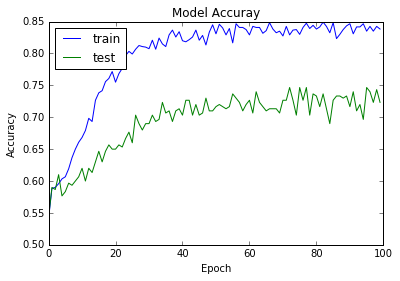

CPU times: user 43.6 s, sys: 2.93 s, total: 46.5 s
Wall time: 44.7 s


In [29]:
%%time
# MODEL FITTING & EVALUATION
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=100, batch_size=50, verbose=0)
scores = model.evaluate(X_test, y_test, verbose=0)
print 'Accuracy: %.2f%%' % (scores[1]*100)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuray')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

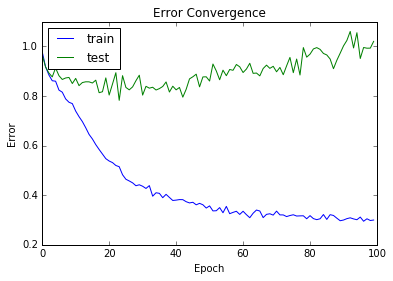

In [30]:
# CONVERGENCE CHECKING
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Error Convergence')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()